Environment Setup

Use magnitudes and phases resulting from DFT as input.
Input size now x2.
phase needs to be unwrapped
try conv layer hybrid

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import itertools
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset
import models
import utils
import scipy.signal
import importlib
importlib.reload(models)
importlib.reload(utils)
from models import *
from utils import *
from torch.utils.tensorboard import SummaryWriter


# hyperparameters
samplerate = 16000
num_epochs = 300
hidden_size = 256
second_hidden_size = 256
third_hidden_size = 256
learning_rate = 0.001
# the f0 range is from 50 to 500 Hz, it should cover the longest f0 in the dataset, so 50Hz=0.02s
segment_length_in_seconds = 0.02
# noise level
segment_length_in_samples = int(segment_length_in_seconds * samplerate)
batch_size = 1
representation_type = 'Mel'

# Parameters for the band-pass filter
lowcut = 50.0  # Low frequency cut-off in Hz
highcut = 3000.0  # High frequency cut-off in Hz

# STFT parameters
n_fft = 2048
hop_length = 512
window = 'hann'
num_frames = 100


Data set building

(535, 100, 2050)
(535, 100, 2050)


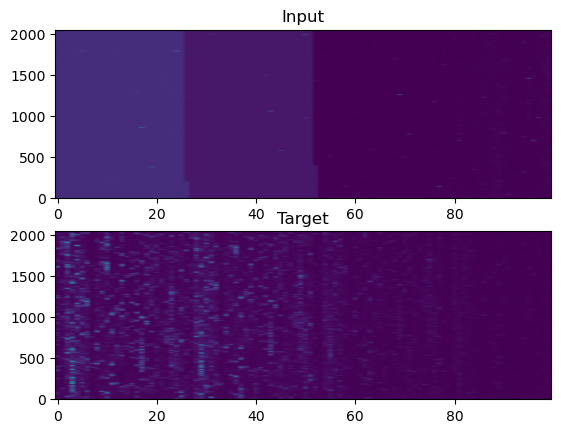

In [4]:
# load all wav files in audio
audio = []
for root, dirs, files in os.walk('audio'):
    for file in files:
        if file.endswith('.wav'):
            audio.append(os.path.join(root, file))
raw_wav = []

# the audio is 2 channel audio, concatenate them along the time axis
for i in range(len(audio)):
    wav, _ = librosa.load(audio[i], sr=samplerate, mono=False)
    raw_wav = np.concatenate((raw_wav, wav), axis=-1) if i != 0 else wav

audio_wav = raw_wav[0]
egg_wav = raw_wav[1]

# split datasets
(audio_wav_train, egg_wav_train), (audio_wav_val, egg_wav_val), (audio_wav_test, egg_wav_test) = split_data(audio_wav, egg_wav)

# Preprocess data for each set
complex_audio_train, complex_egg_train, mag_min, mag_max = preprocess_data(audio_wav_train, egg_wav_train, n_fft, hop_length, window)
complex_audio_val, complex_egg_val, _, _ = preprocess_data(audio_wav_val, egg_wav_val, n_fft, hop_length, window, mag_min, mag_max)
complex_audio_test, complex_egg_test, _, _ = preprocess_data(audio_wav_test, egg_wav_test, n_fft, hop_length, window, mag_min, mag_max)

# Reshape data to fit LSTM
reshaped_mel_input_train = reshape_to_fit_LSTM(complex_audio_train, num_frames)
reshaped_mel_target_train = reshape_to_fit_LSTM(complex_egg_train, num_frames)

reshaped_mel_input_val = reshape_to_fit_LSTM(complex_audio_val, num_frames)
reshaped_mel_target_val = reshape_to_fit_LSTM(complex_egg_val, num_frames)

reshaped_mel_input_test = reshape_to_fit_LSTM(complex_audio_test, num_frames)
reshaped_mel_target_test = reshape_to_fit_LSTM(complex_egg_test, num_frames)

# Create PyTorch datasets
train_dataset = LSTM_VoiceDataset(reshaped_mel_input_train, reshaped_mel_target_train)
val_dataset = LSTM_VoiceDataset(reshaped_mel_input_val, reshaped_mel_target_val)
test_dataset = LSTM_VoiceDataset(reshaped_mel_input_test, reshaped_mel_target_test)

# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check shape of the data
print(reshaped_mel_input_train.shape)
print(reshaped_mel_target_train.shape)

# plot the first frame of the input and target
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(np.log1p(np.abs(reshaped_mel_input_train[0, :, :].T)), aspect='auto', origin='lower')
plt.title('Input')
plt.subplot(2, 1, 2)
plt.imshow(np.log1p(np.abs(reshaped_mel_target_train[0, :, :].T)), aspect='auto', origin='lower')
plt.title('Target')
plt.show()


In [3]:
# check min and max of complex_audio_train
print(np.min(complex_audio_train))
print(np.max(complex_audio_train))


-63025.848
57392.254


In [ ]:
n_mels = (n_fft//2 +1) * 2
model = LSTMmodel(n_mels=n_mels, hidden_size=hidden_size, num_layers=2)
log_name = f'{type(model).__name__}_{representation_type}_bs{batch_size}'
writer = SummaryWriter('runs/experiment_name')

sample_input = torch.randn(batch_size, segment_length_in_samples)
# writer.add_graph(model, sample_input)

tensorboard_log_config(writer, model, representation_type, samplerate, segment_length_in_seconds, batch_size)
trained_model = train_model(writer, model, train_loader, val_loader, num_epochs, learning_rate)
writer.close()


In [ ]:
model.eval()  # Ensure the model is in evaluation mode

predictions = []  # To store model predictions
actuals = []  # To store actual target values for comparison
audios = []  # To store audio samples

with torch.no_grad():  # Disable gradient calculation for efficiency
    for inputs, targets in test_loader:
        # Move data to the appropriate device (e.g., GPU if available)
        inputs = inputs.to(next(model.parameters()).device)
        
        # Compute model output
        output = model(inputs)
        
        predictions.append(output.cpu().numpy())  # Move prediction back to CPU and convert to numpy
        actuals.append(targets.cpu().numpy())  # Same for actual targets

for prediction in predictions:
    # Split the predictions into magnitude and phase components
    pred_mag, pred_phase = np.split(prediction, 2, axis=1)
    
    # Denormalize magnitude and phase
    pred_mag_denorm = denormalize(pred_mag, mag_min, mag_max)
    pred_phase_denorm = denormalize(pred_phase, phase_min, phase_max)
    
    # reconstruct audio from magnitude and phase
    for mag, phase in zip(pred_mag_denorm, pred_phase_denorm):
        audio_reconstructed = reconstruct_signal(mag.squeeze(), phase.squeeze(), hop_length, window)
        audios.append(audio_reconstructed)



In [ ]:
# Plot the input waveform, actual EGG spectrogram, and predicted EGG spectrogram for a random sample
idx = random.randint(0, len(predictions) - 1)
input_mel = reshaped_mel_input_test[idx, :, :]
target_mel = reshaped_mel_target_test[idx, :, :]
prediction_mel = predictions[idx]

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.imshow(np.abs(input_mel.T), aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.title('Input Mel spectrogram')

plt.subplot(3, 1, 2)
plt.imshow(np.abs(target_mel.T), aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.title('Target Mel spectrogram')

plt.subplot(3, 1, 3)
plt.imshow(np.abs(prediction_mel.T), aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.title('Predicted Mel spectrogram')

plt.tight_layout()
plt.show()

# Plot the input waveform, actual EGG waveform, and predicted EGG waveform for a random sample
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(audio_wav_test[idx])
plt.title('Input waveform')

plt.subplot(3, 1, 2)
plt.plot(egg_wav_test[idx])
plt.title('Target waveform')

plt.subplot(3, 1, 3)
plt.plot(audios[idx])
plt.title('Predicted waveform')

plt.tight_layout()
plt.show()